# Determinant analysis

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import os, copy, pickle, itertools, tabulate
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'   # to export text as text, not curves
from IPython.display import Image

import sys
sys.path.append('code')
from functions_response import add_allvariables, compute_determinant, plot_Ivalues, plot_Ivalues_all, load_table, process_gw

## Parameters

In [3]:
label_mapping = { \
                'lambda': "$\lambda$", \
                'Sb': "$S_b$",\
                'Sd': "$S_d$",\
                'tau': "$\\tau$",\
                'tau_cyc': "$\\tau_{cyc}$" , \
                'Si': "$S_i$" , \
                'Delta_bd': "$\Delta_{d}$", \
                'Delta_bi': "$\Delta_{bi}$", \
                'R_bd': "$R_{bd}$", \
                'R_bi': "$R_{bi}$", \
                'Lambda_i_b': "$\Lambda_i^{(b)}$", \
                'Lambda_i': "$\Lambda_i$", \
                'Lambda_i_f': "$\Lambda_i^{(f)}$", \
                'tau_ii_b': "$\\tau_{ii}^{(f)}$", \
                'tau_ii_f': "$\\tau_{ii}^{(f)}$", \
                'delta_id': "$\delta_{id}$", \
                'delta_ii_backward': "$\delta_{ii}^{(b)}$", \
                'delta_ii_forward': "$\delta_{ii}^{(f)}$", \
                'R_ii_b': "$R_{ii}^{(b)}$", \
                'R_ii_f': "$R_{ii}^{(f)}$", \
                'R_id': "$R_{id}$"
                }
nval = 50  # number of values to report in the plot
ext_list = ['.png','.svg']

# division centric variables
vars_div = ['lambda', 'Sb', 'Sd', 'tau', 'tau_cyc', 'Delta_bd', 'Si', 'Delta_bi', 'R_bd', 'R_bi', 'delta_ii_forward', 'delta_ii_backward']
# replication centric variables
vars_rep = ['lambda', 'Lambda_i', 'Lambda_i_b', 'Lambda_i_f', 'Sb', 'Sd', 'tau_cyc', 'tau_ii_b', 'tau_ii_f', 'delta_ii_backward', 'delta_ii_forward', 'delta_id', 'R_ii_b', 'R_ii_f']

direxp = os.path.join('.','experiments')
names_all = []


## List possible combinations

In [4]:
combinations = []
nvar = 3
# division centric variables
for comb in itertools.combinations(vars_div, nvar):
    if not comb in combinations:
        combinations.append(comb)
    
# replication centric variables
for comb in itertools.combinations(vars_rep, nvar):
    if not comb in combinations:
        combinations.append(comb)
    

## Perform determinant analysis on experimental data from Si & Le Treut (2019)

In [5]:
names = ['mg1655_acetate', \
         'mg1655_glucose', \
         'mg1655_glycerol11aa', \
         'ncm3722_arginine', \
         'ncm3722_glucose', \
         'ncm3722_glucose12aa' \
        ]
# names = [
#          'ncm3722_glucose'
#         ]


In [6]:
for name in names:
    fpath = os.path.join(direxp,name,'colidata.pkl')
    print(name, fpath)
    if not name in names_all:
        names_all.append(name)
    outputdir = os.path.join(direxp,name)
#     print(fpath)
    
    colidata = pd.read_pickle(fpath)
    add_allvariables(colidata)
    
    # rename some variables
    col_mapping = { \
                'initiator B': 'tau_bi', \
                'delta_ii': 'delta_ii_backward', \
                }
    colidata = colidata.rename(columns=col_mapping)

    colidata['lambda'] = colidata['lambda']*60
    ncells = len(colidata)
    print("ncells = {:d}".format(ncells))
    
    
    ncells = len(colidata['Lambda_i'].dropna())
    print("ncells (initiation picked) = {:d}".format(ncells))

    ncells = len(colidata.dropna())
    print("ncells (full information) = {:d}".format(ncells))
    
    # determinant analysis
    table = []
    for comb in combinations:
        data = colidata.loc[:,list(comb)].dropna().to_numpy().astype('float64').T
        I = compute_determinant(data)
    #     print(count,comb,"I = {:.4f}".format(I))
        table += [list(comb) + [I] + [data.shape[1]]]

    table.sort(key=lambda x: x[3], reverse=True)
    headers=['var {:d}'.format(i+1) for i in range(nvar)]+['I']+['npts']

    fname = 'determinant_analysis'
    fpath = os.path.join(outputdir,fname + '.txt')

    with open(fpath,'w') as fout:
        fout.write(tabulate.tabulate(table, tablefmt='plain', headers=headers))
    

mg1655_acetate ./experiments/mg1655_acetate/colidata.pkl
ncells = 1554
ncells (initiation picked) = 1554
ncells (full information) = 519
mg1655_glucose ./experiments/mg1655_glucose/colidata.pkl
ncells = 1807
ncells (initiation picked) = 1807
ncells (full information) = 1283
mg1655_glycerol11aa ./experiments/mg1655_glycerol11aa/colidata.pkl
ncells = 1491
ncells (initiation picked) = 1491
ncells (full information) = 500
ncm3722_arginine ./experiments/ncm3722_arginine/colidata.pkl
ncells = 1701
ncells (initiation picked) = 1701
ncells (full information) = 920
ncm3722_glucose ./experiments/ncm3722_glucose/colidata.pkl
ncells = 1432
ncells (initiation picked) = 1432
ncells (full information) = 650
ncm3722_glucose12aa ./experiments/ncm3722_glucose12aa/colidata.pkl
ncells = 1464
ncells (initiation picked) = 1464
ncells (full information) = 203


## Perform determinant analysis on experimental data from Witz et al (2019)

In [7]:
# parameters
mapping_dict = {'glycerol': { \
                             'dir': '20180706_GW296_glycerol37_1_MMStack', \
                             'period': 0 \
                            }, 
                'glucose': { \
                           'dir': '20180711_GW296_glucose37_1_MMStack', \
                            'period': 0 \
                           },
                'glucose8a': { \
                               'dir': '20180709_GW296_glucose8aa37_1_MMStack', \
                               'period': 0 \
                              },
                'glycerolauto': { \
                                'dir': '20170327_GW339_temp', \
                                 'period': 1
                                }
            }
# period from `dataset_fig_5AB.ipynb' notebook
size_columns = ['length', 'Lb', 'Lb_fit', 'Ld_fit', 'Ld', 'Li', 'Li_fit', 'DLi', 'Li_old']
size_scale = 0.065 # nm/px
time_scale = 3 # min / frame
# fitting = False

# data exported by Witz et al.
fpath=os.path.join('..','Data_export','Fig1_2_3.csv')
df_export = pd.read_csv(fpath)
names_export = df_export['condition'].unique().tolist()
match_export = False   # set True to match exported_data in following analysis
dec = 4               # decimals when rounding up lambda_inv for mapping
suf = ""
if (match_export):
    fitting=True
#     suf = "_match_export"
else:
    fitting=False
#     suf = ""

In [8]:
# load files
names = list(mapping_dict.keys())
# names=['glucose8a']
for name in names:
    fpath = os.path.join('..','PreProcessed', mapping_dict[name]['dir'], 'colidata.pkl')
    print(name, fpath)
    if not name in names_all:
        names_all.append(name)
    colidata = pd.read_pickle(fpath)

    outputdir = os.path.join(direxp, name)
    if not os.path.isdir(outputdir):
        os.makedirs(outputdir)

    # rescale size
    func = lambda x: x*size_scale
    colidata[size_columns] = colidata[size_columns].apply(func)
    
    # remove cells without enough data points
    func = lambda x:  len(x) < 2
    idx = colidata['length'].apply(func)
    colidata.drop(colidata.index[idx], axis=0, inplace=True)
    
    # process data
    process_gw(colidata, time_scale, fitting)
    
    # save this dataframe
    fpath = os.path.join(outputdir,'colidata.pkl')
    colidata.to_pickle(fpath)
    print(fpath)
    
    # add variables
    add_allvariables(colidata, gw=True)

    # rename some variables
    col_mapping = { \
                'initiator B': 'tau_bi', \
                'delta_ii': 'delta_ii_backward', \
                'delta_id_m1': 'delta_id'
                }
    colidata.rename(columns=col_mapping, inplace=True)

    # rescale growth rate
    colidata['lambda'] = colidata['lambda']*60

    # filter data
    ncells = len(colidata)
    print("ncells (pre-filter) = {:d}".format(ncells))
    
    ## period
    period = mapping_dict[name]['period']
    idx = colidata['period'] == period
    colidata = colidata.loc[idx]
    
    ## with reference data set
    if match_export and (name in names_export):
        df_ref = df_export.loc[df_export['condition'] == name]
        set_ref = set(df_ref['lambda_inv'].dropna().round(dec).unique().tolist())
        set_data = set(colidata['tau_eff'].dropna().round(dec).unique().tolist())
        selection = list(set_data.intersection(set_ref))
        idx = colidata['tau_eff'].round(dec).isin(selection)
        colidata.drop(colidata.index[~idx], axis=0, inplace=True)
        
    ncells = len(colidata)
    print("ncells (post-filter) = {:d}".format(ncells))

    ncells = len(colidata['Lambda_i'].dropna())
    print("ncells (initiation picked) = {:d}".format(ncells))

    ncells = len(colidata.dropna())
    print("ncells (full information) = {:d}".format(ncells))


#     idx = colidata.dropna().index
    # determinant analysis
    table = []
    for comb in combinations:
        data = colidata.loc[:,list(comb)].dropna().to_numpy().astype('float64').T
        I = compute_determinant(data)
    #     print(count,comb,"I = {:.4f}".format(I))
        table += [list(comb) + [I] + [data.shape[1]]]

    table.sort(key=lambda x: x[3], reverse=True)
    headers=['var {:d}'.format(i+1) for i in range(nvar)]+['I']+['npts']

    fname = 'determinant_analysis' + suf
    fpath = os.path.join(outputdir,fname + '.txt')

    with open(fpath,'w') as fout:
        fout.write(tabulate.tabulate(table, tablefmt='plain', headers=headers))

glycerol ../PreProcessed/20180706_GW296_glycerol37_1_MMStack/colidata.pkl
./experiments/glycerol/colidata.pkl
ncells (pre-filter) = 865
ncells (post-filter) = 865
ncells (initiation picked) = 811
ncells (full information) = 395
glucose ../PreProcessed/20180711_GW296_glucose37_1_MMStack/colidata.pkl
./experiments/glucose/colidata.pkl
ncells (pre-filter) = 1094
ncells (post-filter) = 1094
ncells (initiation picked) = 994
ncells (full information) = 479
glucose8a ../PreProcessed/20180709_GW296_glucose8aa37_1_MMStack/colidata.pkl
./experiments/glucose8a/colidata.pkl
ncells (pre-filter) = 1251
ncells (post-filter) = 1251
ncells (initiation picked) = 1118
ncells (full information) = 568
glycerolauto ../PreProcessed/20170327_GW339_temp/colidata.pkl
./experiments/glycerolauto/colidata.pkl
ncells (pre-filter) = 3611
ncells (post-filter) = 3018
ncells (initiation picked) = 2548
ncells (full information) = 862


## Print ranking for main models.

In [9]:
# the 3 special combinations
special_combs = {\
                 'GW (backward)': ['lambda', 'delta_ii_backward', 'delta_id'], \
                 'GW (forward)': ['lambda', 'delta_ii_forward', 'delta_id'], \
                 'HC': ['lambda', 'tau_cyc', 'Lambda_i'], \
                 'SLT (backward)': ['lambda', 'Delta_bd', 'delta_ii_backward'], \
                 'SLT (forward)': ['lambda', 'Delta_bd', 'delta_ii_forward']
                }
special_colors = ['darkblue', 'yellow', 'darkred', 'darkgreen']

In [10]:
for name in names_all:
# for name in names:
    print('-'*10)
    print(name)
    
    fname = 'determinant_analysis' + suf
    fpath = os.path.join(direxp,name,fname + '.txt')
    table = load_table(fpath)

    for key in special_combs.keys():
        myvars = set(special_combs[key])
        for line in table:
            thisvars = set(line[:3])
            I = float(line[3])
            npts = int(line[4])
            if myvars == thisvars:
                print("{:<20s}I = {:.6f}  (npts = {:d})".format(key,I,npts))
                break

----------
mg1655_acetate
GW (backward)       I = 0.814357  (npts = 1074)
GW (forward)        I = 0.924268  (npts = 1074)
HC                  I = 0.417602  (npts = 1554)
SLT (backward)      I = 0.648092  (npts = 1074)
SLT (forward)       I = 0.829172  (npts = 1074)
----------
mg1655_glucose
GW (backward)       I = 0.908310  (npts = 1640)
GW (forward)        I = 0.875542  (npts = 1640)
HC                  I = 0.471560  (npts = 1807)
SLT (backward)      I = 0.879010  (npts = 1640)
SLT (forward)       I = 0.833507  (npts = 1640)
----------
mg1655_glycerol11aa
GW (backward)       I = 0.851348  (npts = 1233)
GW (forward)        I = 0.812516  (npts = 1233)
HC                  I = 0.497346  (npts = 1491)
SLT (backward)      I = 0.769906  (npts = 1233)
SLT (forward)       I = 0.713263  (npts = 1233)
----------
ncm3722_arginine
GW (backward)       I = 0.800610  (npts = 1247)
GW (forward)        I = 0.807433  (npts = 1247)
HC                  I = 0.671608  (npts = 1701)
SLT (backward)      I = 0

### Make plots

In [11]:
# the 3 special combinations
special_combs = {\
                 'GW': ['lambda', 'delta_ii_backward', 'delta_id'], \
#                  'GW (forward)': ['lambda', 'delta_ii_forward', 'delta_id'], \
                 'HC': ['lambda', 'tau_cyc', 'Lambda_i'], \
                 'SLT': ['lambda', 'Delta_bd', 'delta_ii_forward'], \
                }
special_colors = ['darkblue', 'darkred', 'darkgreen']

In [12]:
specials = [comb for comb in special_combs.values()]
for name in names_all:
    print('-'*10)
    print(name)
    
    # load data
    fname = 'determinant_analysis'
    fpath = os.path.join(direxp,name,fname + '.txt')
    table = load_table(fpath)
    
    # make figure
    ## first figure
    fname = "determinant_analysis_top{:d}".format(nval) + suf
    fpath = os.path.join(direxp,name,fname)
    figname = name + suf
    fig = plot_Ivalues(table, label_mapping, fig_title=figname, nval=nval, figsize=(3,12), fmt_str='{:.4f}', specials=specials, special_colors=special_colors)
    
    for ext in ext_list:
        fig.savefig(fpath+ext, dpi=300, bbox_inches='tight', pad_inches=0)
        print("Saved figure in {:s}".format(fpath+ext))
#     fig.clf()
    plt.close('all')
    


    ## second figure
    fname = "determinant_analysis_all" + suf
    fpath = os.path.join(direxp,name,fname)
    figname = name + suf

    fig = plot_Ivalues_all(table, fig_title=figname, figsize=(12,3), fmt_str='{:.4f}', specials=specials, special_colors=special_colors)
    
    for ext in ext_list:
        fig.savefig(fpath+ext, dpi=300, bbox_inches='tight', pad_inches=0)
        print("Saved figure in {:s}".format(fpath+ext))
#     fig.clf()
    plt.close('all')

----------
mg1655_acetate


code/functions_response.py:1948: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1949: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_acetate/determinant_analysis_top50.png
Saved figure in ./experiments/mg1655_acetate/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2005: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2006: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_acetate/determinant_analysis_all.png
Saved figure in ./experiments/mg1655_acetate/determinant_analysis_all.svg
----------
mg1655_glucose


code/functions_response.py:1948: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1949: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_glucose/determinant_analysis_top50.png
Saved figure in ./experiments/mg1655_glucose/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2005: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2006: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_glucose/determinant_analysis_all.png
Saved figure in ./experiments/mg1655_glucose/determinant_analysis_all.svg
----------
mg1655_glycerol11aa


code/functions_response.py:1948: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1949: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_glycerol11aa/determinant_analysis_top50.png
Saved figure in ./experiments/mg1655_glycerol11aa/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2005: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2006: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_glycerol11aa/determinant_analysis_all.png
Saved figure in ./experiments/mg1655_glycerol11aa/determinant_analysis_all.svg
----------
ncm3722_arginine
Found special combination!


code/functions_response.py:1948: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1949: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_arginine/determinant_analysis_top50.png
Saved figure in ./experiments/ncm3722_arginine/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2005: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2006: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_arginine/determinant_analysis_all.png
Saved figure in ./experiments/ncm3722_arginine/determinant_analysis_all.svg
----------
ncm3722_glucose
Found special combination!
Found special combination!


code/functions_response.py:1948: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1949: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_glucose/determinant_analysis_top50.png
Saved figure in ./experiments/ncm3722_glucose/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2005: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2006: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_glucose/determinant_analysis_all.png
Saved figure in ./experiments/ncm3722_glucose/determinant_analysis_all.svg
----------
ncm3722_glucose12aa


code/functions_response.py:1948: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1949: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_glucose12aa/determinant_analysis_top50.png
Saved figure in ./experiments/ncm3722_glucose12aa/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2005: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2006: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_glucose12aa/determinant_analysis_all.png
Saved figure in ./experiments/ncm3722_glucose12aa/determinant_analysis_all.svg
----------
glycerol


code/functions_response.py:1948: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1949: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glycerol/determinant_analysis_top50.png
Saved figure in ./experiments/glycerol/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2005: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2006: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glycerol/determinant_analysis_all.png
Saved figure in ./experiments/glycerol/determinant_analysis_all.svg
----------
glucose
Found special combination!
Found special combination!


code/functions_response.py:1948: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1949: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glucose/determinant_analysis_top50.png
Saved figure in ./experiments/glucose/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2005: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2006: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glucose/determinant_analysis_all.png
Saved figure in ./experiments/glucose/determinant_analysis_all.svg
----------
glucose8a
Found special combination!
Found special combination!


code/functions_response.py:1948: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1949: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glucose8a/determinant_analysis_top50.png
Saved figure in ./experiments/glucose8a/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2005: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2006: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glucose8a/determinant_analysis_all.png
Saved figure in ./experiments/glucose8a/determinant_analysis_all.svg
----------
glycerolauto
Found special combination!


code/functions_response.py:1948: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1949: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glycerolauto/determinant_analysis_top50.png
Saved figure in ./experiments/glycerolauto/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2005: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2006: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glycerolauto/determinant_analysis_all.png
Saved figure in ./experiments/glycerolauto/determinant_analysis_all.svg


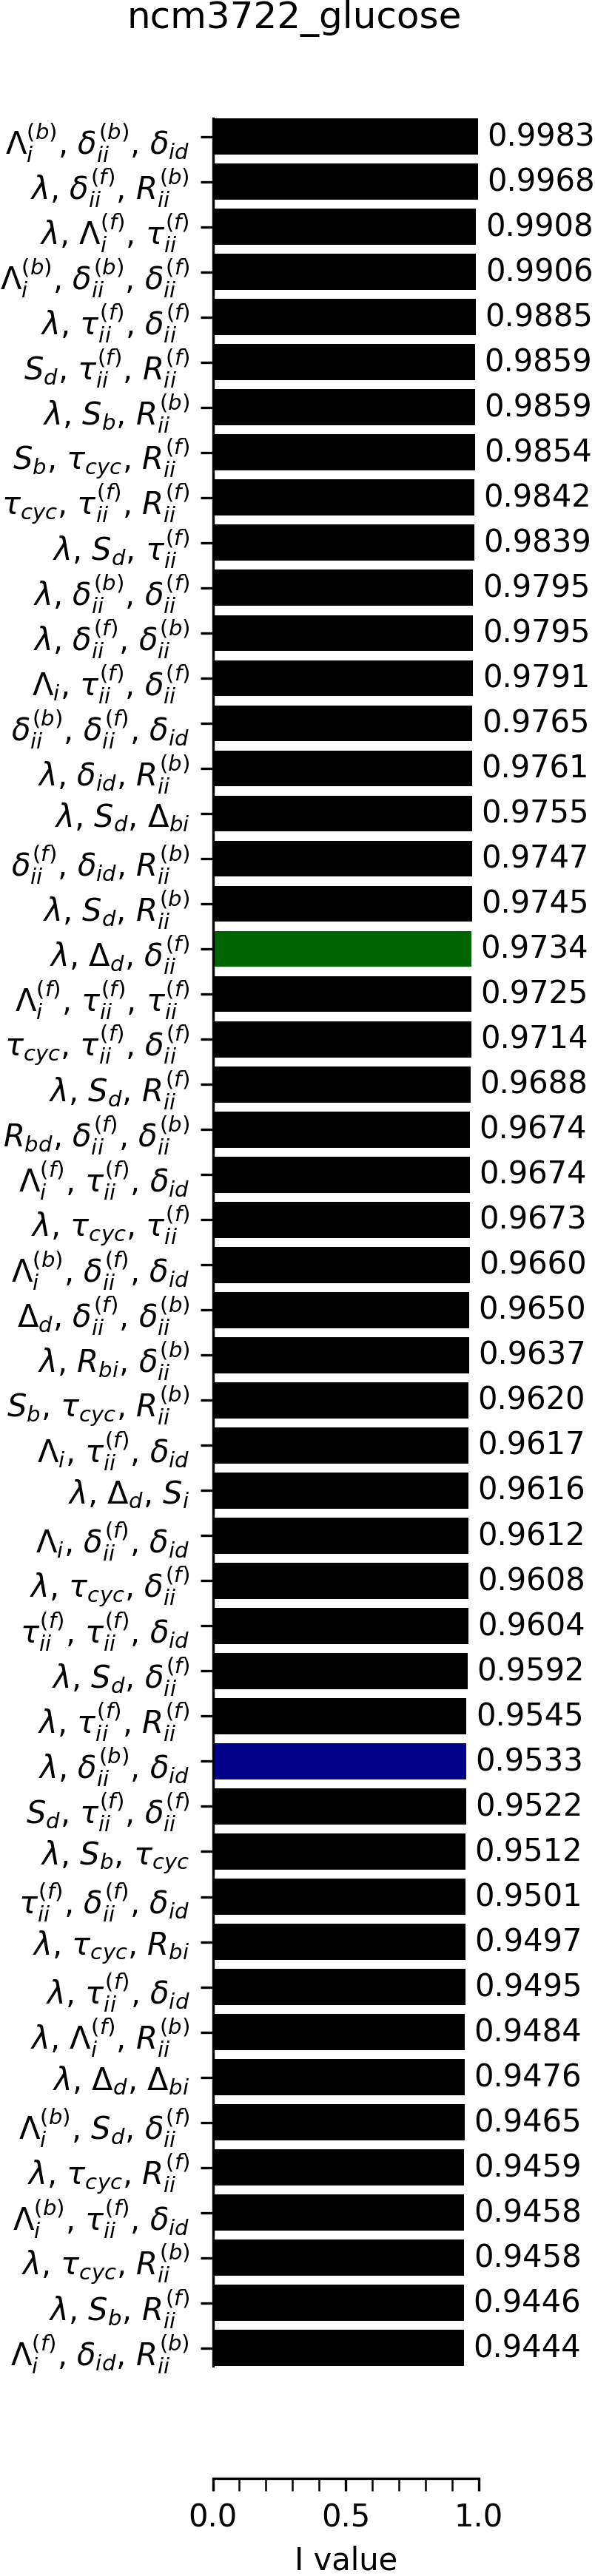

In [13]:
name = 'ncm3722_glucose'

# first figure
fname = "determinant_analysis_top{:d}".format(nval) + '.png'
fpath = os.path.join(direxp,name,fname)
# display one of the previous figures
Image(filename=fpath) 

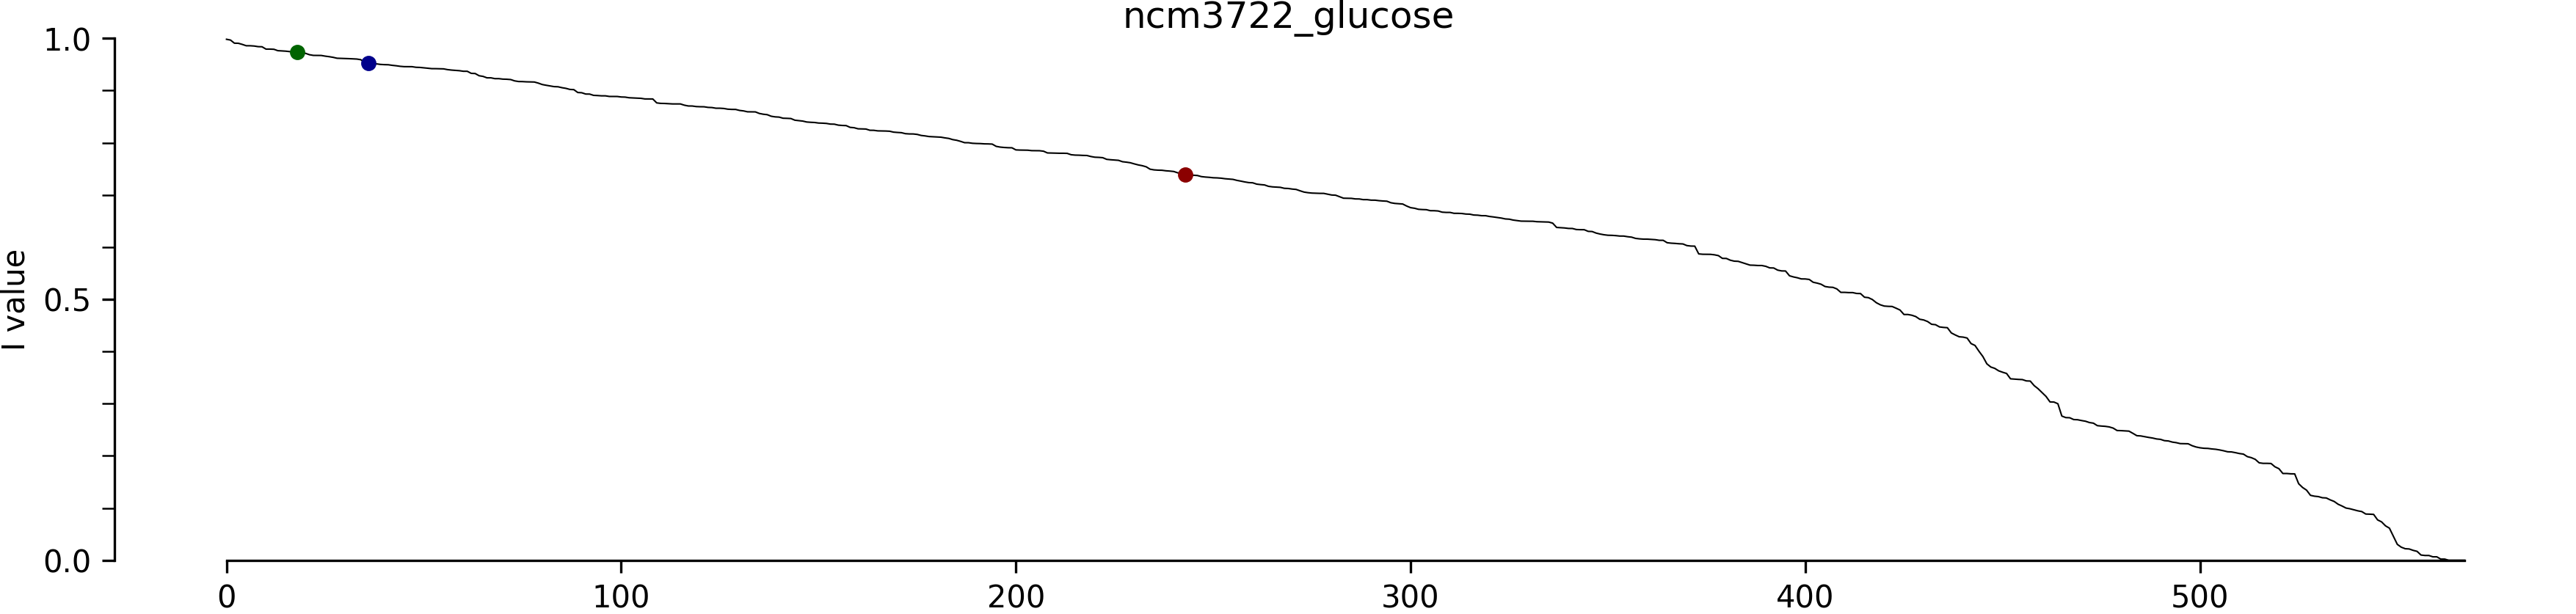

In [14]:
# second figure
fname = "determinant_analysis_all".format(nval) + '.png'
fpath = os.path.join(direxp,name,fname)
# display one of the previous figures
Image(filename=fpath) 

## Overall score

In [15]:
scores = []
for comb in combinations:
    scores += [list(comb) + [None, None, None]]


In [16]:
for i in range(len(scores)):
    score = scores[i]
    comb = score[:3]
    
    ranks = []
    for name in names_all:
        fname = 'determinant_analysis' + suf
        fpath = os.path.join(direxp,name,fname + '.txt')
        table = load_table(fpath)
        
        for j in range(len(table)):
            line = table[j]
            thiscomb = line[:3]
            
            if thiscomb == comb:
                ranks.append(j+1)
                break
        # end reading all file
    # end loop on conditions
    score[3] = np.sort(ranks)[int(len(ranks)/2)-1]
    score[4] = len(ranks)

medranks = [score[3] for score in scores]
values = np.sort(np.unique(medranks))
for score in scores:
    medrank = score[3]
    score[5] = values.tolist().index(medrank) + 1

scores.sort(key=lambda x: x[3])
headers=['var {:d}'.format(i+1) for i in range(nvar)]+['median rank', 'nexp', 'final rank']

fname = 'determinant_analysis_synthesis' + suf
fpath = os.path.join(direxp,fname + '.txt')

with open(fpath,'w') as fout:
    fout.write(tabulate.tabulate(scores, tablefmt='plain', headers=headers))